Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/FTRCE/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 1.6
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:235
┌ Warning: 7.090725019558511 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Info:  Adapted ϵ = 0.5474061641531609, std = [1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/adapt.jl:91
[NUTS] Finished with
  Running time        = 6.008683206;
  #lf / sample        = 0.0;
  #evals / sample     = 10.383;
  pre-cond. metric    = [1.0].


Look at the generated draws (in chn)

In [8]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean          SD       Naive SE       MCSE         ESS   
  lf_num  0.0000000000 0.000000000 0.0000000000 0.0000000000        NaN
 elapsed  0.0030043416 0.088839637 0.0019865147 0.0024638674 1300.10635
 epsilon  0.5723265739 0.224275486 0.0050149523 0.0172598931  168.84469
   theta  0.6423535874 0.140858104 0.0031496830 0.0052424508  721.92978
      lp -3.3301299046 0.785064701 0.0175545804 0.0356347510  485.35940
eval_num 10.3830000000 6.105567130 0.1365246314 0.1584814450 1484.20939
  lf_eps  0.5723265739 0.224275486 0.0050149523 0.0172598931  168.84469

Quantiles:
              2.5%           25.0%         50.0%        75.0%        97.5%    
  lf_num  0.00000000000  0.00000000000  0.000000000  0.000000000  0.0000000000
 elapsed  0.00016076495  0.00021820225  0.000438145  0.000518571  0.0012147294
 epsilon  0.37927583734  0.54740616415  0.547406164  0.547406164 

Look at the mean and sd

In [9]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.6426095884085574, 0.14020747435605263)



Fix the inclusion of adaptation samples

In [10]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.0123694 … 10.0 0.547406; 0.0 0.000715755 … 10.0 0.547406; … ; 0.0 0.000429021 … 10.0 0.547406; 0.0 0.000427298 … 10.0 0.547406]

Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean                 SD                     Naive SE               MCSE          ESS   
  lf_num  0.0000000000 0.00000000000000000000000 0.000000000000000000000000 0.000000000000        NaN
 elapsed  0.0005292463 0.00073718905542076711580 0.000017375712670151000500 0.000018931349 1516.33315
 epsilon  0.5474061642 0.00000000000000066631893 0.000000000000000015705288 0.000000000000 1800.00000
   theta  0.6426095884 0.14020747435605263042646 0.003304721863006792378220 0.005733301743  598.04344
      lp -3.3264206648 0.79427113083509026658646 0.018721150090473329119511 0.038997056272  414.83358
eval_num 10.2966666667 5.66655342179402676805466 0.133561945016879707326396 0.149703410486 1432.76375
  lf_eps  0.5474061642 0.00000000000000066631893 0.000000000000000015705288 0.000000000000 1800.00000

Quantiles:
              2.5%          25.0%         50.0%         75.0% 

Compute at hpd region

In [12]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

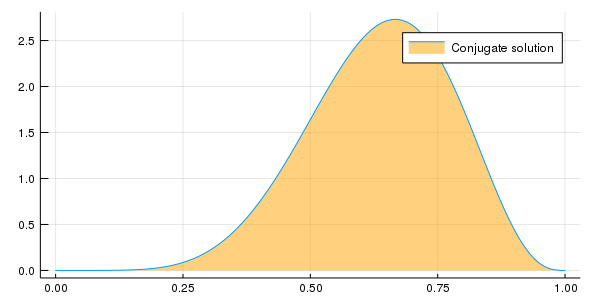

In [13]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

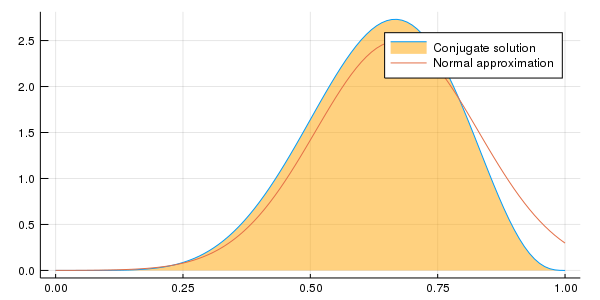

In [14]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

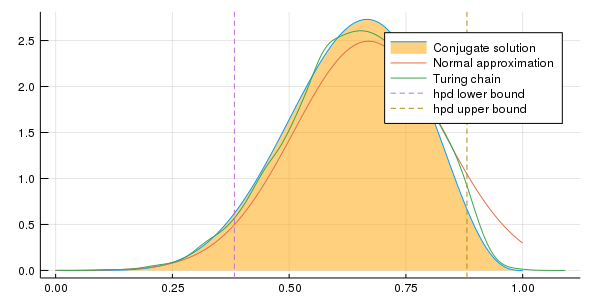

In [15]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [16]:
println("hpd bounds = $bnds\n")

hpd bounds =        94% Lower  94% Upper
theta 0.38277635 0.88066497





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*